# Model Monitoring for Cardiac Image Segmentation

## Import

In [ ]:
import os
import random
import operator
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as data_utils
import nibabel as nib
from medpy.metric import binary

#use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Import data

In [ ]:
!mkdir data
#training set
!python gdrivedl.py https://drive.google.com/open?id=1bxRj0zf-iMooYA4jUZS_zS4VD9NLYxE4 data/
#predictions
!python gdrivedl.py https://drive.google.com/open?id=1P2kNGllKUKmumaCM2IsqgIgRPAKEXa59 data/

In [ ]:
!unzip -q data/training.zip -d data/

In [ ]:
!unzip -q data/predictions.zip -d data/
!mv data/predictions data/testing

## Data preparation

In [ ]:
gt=get_gt("data/training/")

In [ ]:
images_gt=np.array([img for _,img in gt["ED"]]+[img for _,img in gt["ES"]])
blank=torch.zeros(images_gt.shape[:1]+(len(np.unique(images_gt)),)+images_gt.shape[1:],dtype=int)
images_gt=blank.scatter_(1,torch.tensor(np.expand_dims(images_gt,axis=1)),1)

In [ ]:
BATCH_SIZE = 8

images_train = images_gt[:int(np.floor(.8*images_gt.shape[0]))]
images_val = images_gt[int(np.floor(.8*images_gt.shape[0])):]

train_loader = torch.utils.data.DataLoader(
    data_utils.TensorDataset(images_train.float()),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    data_utils.TensorDataset(images_val.float()),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

## Training

In [ ]:
ae = AE(latent_size=100).to(device)
print(ae)

AE(
  (encoder): Sequential(
    (0): Conv2d(4, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Dropout(p=0.5, inplace=False)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.2)
    (15): Dropout(p=0.5, inplace=False

In [ ]:
ae.train()
history = ae.training_routine(500,train_loader,val_loader)

Epoch [0], GDLoss: 0.2927 MSELoss: 0.0402 Total: 0.3330 
Epoch [1], GDLoss: 0.1206 MSELoss: 0.0186 Total: 0.1392 
Epoch [2], GDLoss: 0.0732 MSELoss: 0.0169 Total: 0.0901 
Epoch [3], GDLoss: 0.0574 MSELoss: 0.0167 Total: 0.0741 
Epoch [4], GDLoss: 0.0499 MSELoss: 0.0166 Total: 0.0666 
Epoch [5], GDLoss: 0.0442 MSELoss: 0.0128 Total: 0.0571 
Epoch [6], GDLoss: 0.0329 MSELoss: 0.0100 Total: 0.0429 
Epoch [7], GDLoss: 0.0263 MSELoss: 0.0092 Total: 0.0355 
Epoch [8], GDLoss: 0.0233 MSELoss: 0.0091 Total: 0.0324 
Epoch [9], GDLoss: 0.0228 MSELoss: 0.0095 Total: 0.0323 
Epoch [10], GDLoss: 0.0221 MSELoss: 0.0094 Total: 0.0315 
Epoch [11], GDLoss: 0.0223 MSELoss: 0.0095 Total: 0.0318 
Epoch [12], GDLoss: 0.0223 MSELoss: 0.0096 Total: 0.0318 
Epoch [13], GDLoss: 0.0222 MSELoss: 0.0097 Total: 0.0319 
Epoch [14], GDLoss: 0.0220 MSELoss: 0.0096 Total: 0.0316 
Epoch [15], GDLoss: 0.0229 MSELoss: 0.0102 Total: 0.0330 
Epoch [16], GDLoss: 0.0219 MSELoss: 0.0098 Total: 0.0317 
Epoch [17], GDLoss: 0.02

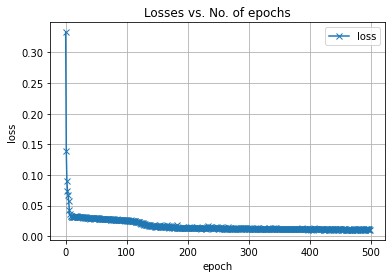

In [ ]:
plot_history(history)

## Testing

In [ ]:
# LOAD MODEL
ae=torch.load("best_ae.pth",map_location=device)
ae.eval();

### Data preparation

In [ ]:
model="Bai"
test=get_test("data/testing/"+model+"/")

In [ ]:
images_test=np.array([img for _,img in test["ED"]]+[img for _,img in test["ES"]])
blank=torch.zeros(images_test.shape[:1]+(len(np.unique(images_test)),)+images_test.shape[1:],dtype=int)
images_test=blank.scatter_(1,torch.tensor(np.expand_dims(images_test,axis=1)),1)

In [ ]:
BATCH_SIZE=8

test_loader = torch.utils.data.DataLoader(
    data_utils.TensorDataset(images_test.float()),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=0
    )

### Single patient

In [ ]:
patient="patient102"

if patient=="empty":
  reference=np.zeros([1,4,256,256])
  reference[:,0]=1
else:
  reference=images_test[np.array([p for p,_ in test["ED"]]+[p for p,_ in test["ES"]])==patient].numpy()

In [ ]:
%time
prediction=ae(torch.tensor(reference).float().to(device)).cpu().detach().numpy()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [ ]:
reference=np.argmax(reference,axis=1)
prediction={
    "discrete":np.argmax(prediction,axis=1),
    "continuous":np.argmax(prediction,axis=1)+(1-np.max(prediction,axis=1))
}

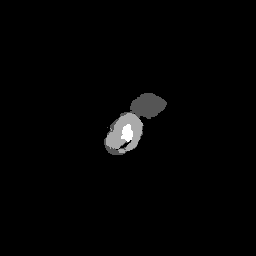

In [ ]:
display_image(reference[2])

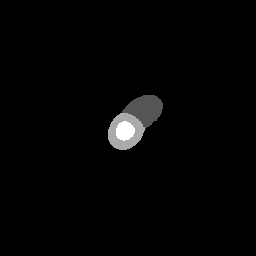

In [ ]:
display_image(prediction["discrete"][2])

In [ ]:
%time
get_results(prediction["discrete"],reference)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


{'Dice': 1.1338108710046348,
 'Dice_rint': 0.8360469519121545,
 'HD_rint': 8.94427190999916,
 'LV_Dice': 0.8735942420152947,
 'LV_Dice_rint': 0.6360956436292171,
 'LV_HD_rint': 7.0710678118654755,
 'LV_SED': 9999,
 'LV_SED_rint': 9999.0,
 'LV_maxSED': 1719,
 'LV_maxSED_rint': 1719.0,
 'MYO_Dice': 0.955721072077884,
 'MYO_Dice_rint': 0.7268510258697591,
 'MYO_HD_rint': 5.656854249492381,
 'MYO_SED': 12248,
 'MYO_SED_rint': 12248.0,
 'MYO_maxSED': 2232,
 'MYO_maxSED_rint': 2232.0,
 'RV_Dice': 0.5863665053650327,
 'RV_Dice_rint': 0.5863665053650327,
 'RV_HD_rint': 41.340053217188775,
 'RV_SED': 3932,
 'RV_SED_rint': 3932.0,
 'RV_maxSED': 839,
 'RV_maxSED_rint': 839.0,
 'SED': 8875,
 'SED_rint': 8875.0,
 'maxSED': 1614,
 'maxSED_rint': 1614.0}

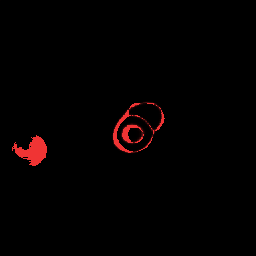

In [ ]:
display_difference(prediction["continuous"][2],reference[2])

### All patients

In [ ]:
reference=np.array([img for _,img in test["ED"]]+[img for _,img in test["ES"]])

In [ ]:
prediction=np.array([])
for [batch] in test_loader:
  batch=batch.to(device)
  reconstruction=ae(batch).cpu().detach().numpy()
  if(len(prediction)==0):
    prediction=reconstruction
  else:
    prediction=np.concatenate([prediction,reconstruction])

In [ ]:
prediction=np.argmax(prediction,axis=1)

In [ ]:
results={"ED":{},"ES":{}}
for patient in np.unique([p for p,_ in test["ED"]]+[p for p,_ in test["ES"]]):
  results["ED"][patient]=get_results(prediction[:len(test["ED"])][np.array([p for p,_ in test["ED"]])==patient],reference[:len(test["ED"])][np.array([p for p,_ in test["ED"]])==patient])
  results["ES"][patient]=get_results(prediction[len(test["ED"]):][np.array([p for p,_ in test["ES"]])==patient],reference[len(test["ED"]):][np.array([p for p,_ in test["ES"]])==patient])

In [ ]:
np.save(model+'_AE_ED+ES',results)